In [8]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

In [39]:
ds = load_1minute_fx_bars('EURUSD',2009)['close']

In [40]:
ds2 = load_1minute_fx_bars('XAUGBP',2009)['close']

In [41]:
day = 24*60

In [60]:
ds2.head()

ts
2009-05-03 17:00:00    594.60
2009-05-03 17:57:00    594.50
2009-05-03 17:58:00    594.50
2009-05-03 17:59:00    594.50
2009-05-03 18:00:00    594.13
Name: close, dtype: float64

In [43]:
def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh((sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return  np.tanh((sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

In [44]:
def normalise_price(p, vol_adjust=None):
    px = logreturn(p, p.shift(1)).cumsum()
    if vol_adjust:
        px = px / ewm_vol(px, com=vol_adjust)
    return px

def ewm_vol(p,com):
    return p.diff().ewm(com, min_periods=com).std()

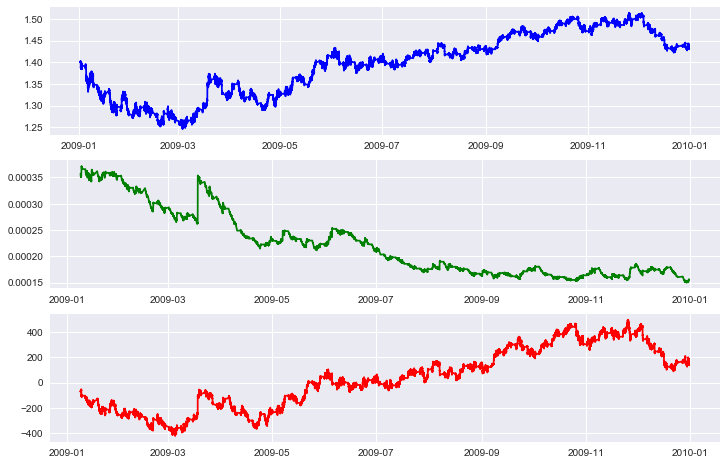

In [45]:
fig, ax = plt.subplots(3, figsize=(12,8))
ax[0].plot(ds,'b-')
ax[1].plot(ewm_vol(normalise_price(ds), 5*day),'g-')
ax[2].plot(normalise_price(ds,5*day),'r-')


#ax[0,1].plot(ds2)
#ax[1,1].plot(normalise_price(ds2))

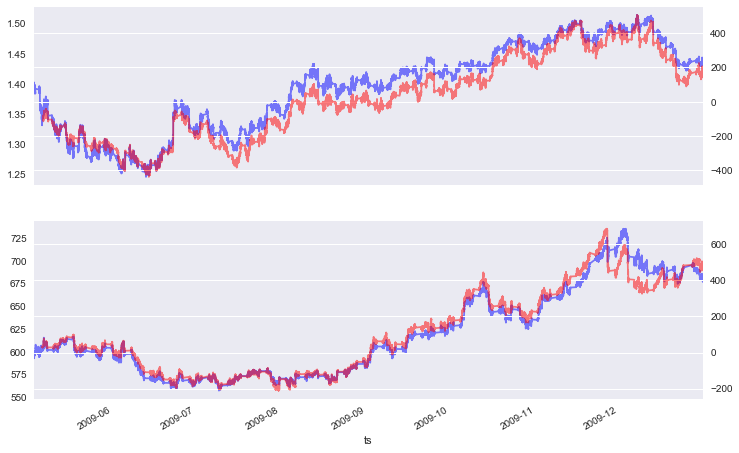

In [46]:
vol_window = 3*day
fig, ax = plt.subplots(2, figsize=(12,8))

ds.plot(style='b-',ax=ax[0], alpha=0.5)
normalise_price(ds,vol_window).plot(style='r-', ax=ax[0], alpha=0.5,secondary_y=True)

ds2.plot(style='b-',ax=ax[1], alpha=0.5)
normalise_price(ds2,vol_window).plot(style='r-', ax=ax[1], alpha=0.5, secondary_y=True)


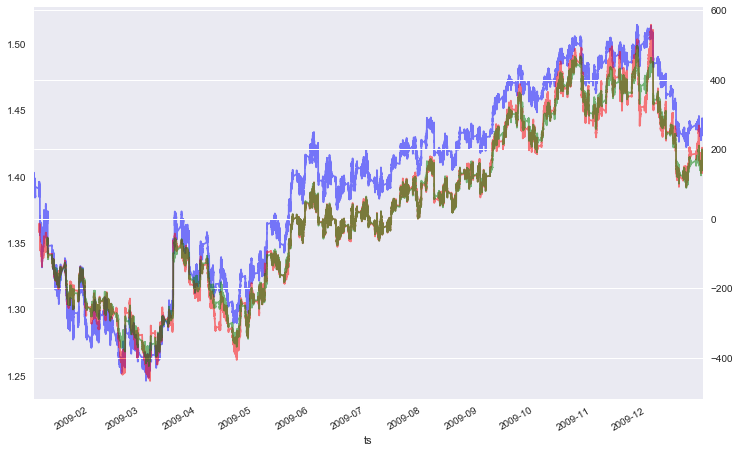

In [47]:
fig = plt.figure( figsize=(12,8))

ds.plot(style='b-',alpha=0.5)
normalise_price(ds,1*day).plot(style='r-',  alpha=0.5,secondary_y=True)
normalise_price(ds,5*day).plot(style='g-',  alpha=0.5,secondary_y=True)



In [48]:
vol_window = 24*60*5
vol_window

7200

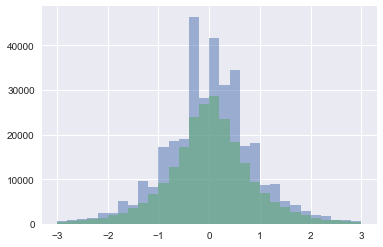

In [49]:
normalise_price(ds,vol_window).diff().hist(bins=30, range=(-3,3), alpha=0.5)
normalise_price(ds2,vol_window).diff().hist(bins=30, range=(-3,3), alpha=0.5)

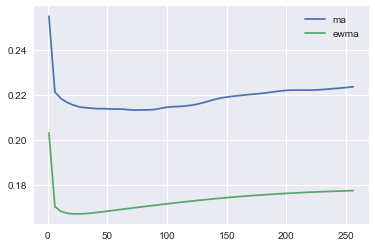

In [50]:
xs = []
ys1 = []
ys2 = []

px = normalise_price(ds, 5*day)
for a in np.linspace(1,256,50):
    a = int(a)
    xs.append(a)
    ys1.append(masig(px, 2*a,a).std())
    ys2.append(ewmasig(px, 2*a,a).std())
plt.plot(xs,ys1, label='ma')
plt.plot(xs,ys2, label='ewma')
plt.legend()

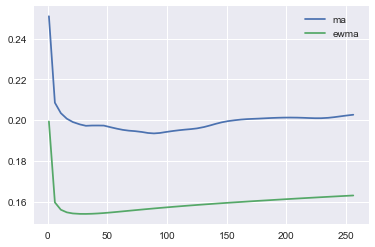

In [51]:
xs = []
ys1 = []
ys2 = []

px = normalise_price(ds2, 5*day)
for a in np.linspace(1,256,50):
    a = int(a)
    xs.append(a)
    ys1.append(masig(px, 2*a,a).std())
    ys2.append(ewmasig(px, 2*a,a).std())
plt.plot(xs,ys1, label='ma')
plt.plot(xs,ys2, label='ewma')
plt.legend()

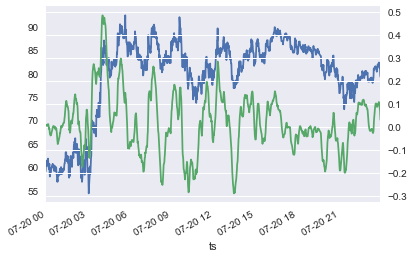

In [61]:
px = normalise_price(ds, 5*day)
p = px['2009-07-20']
p.plot()
ewmasig(p,32,16).plot(secondary_y=True)

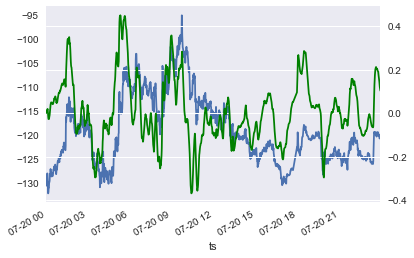

In [62]:
px = normalise_price(ds2, 5*day)
p = px['2009-07-20']
p.plot()
ewmasig(p,32,16).plot(color='g', secondary_y=True)

In [63]:
display(normalise_price(ds, 5*day).diff().describe())
display(normalise_price(ds2, 5*day).diff().describe())

count    348678.000000
mean          0.000612
std           0.995586
min         -29.335972
25%          -0.408832
50%           0.004722
75%           0.440119
max         104.565343
Name: close, dtype: float64

count    233514.000000
mean          0.001778
std           0.992176
min         -25.285857
25%          -0.466985
50%           0.003539
75%           0.483017
max          34.173695
Name: close, dtype: float64

In [79]:
def add_features(px):
    df = pd.DataFrame({'px':px})
    for period in [2,4,8,16,32,64,128,256]:
        df['ret-{}'.format(period)] = np.tanh(0.33* (px - px.shift(period) )/ np.sqrt(period))
        #df['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
        df['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)
    return df

In [80]:
def preprocess(ds):
    day = 24*60    
    px = normalise_price(ds, vol_adjust=5*day)
    df = add_features(px)
    return df


In [81]:
preprocess(load_1minute_fx_bars('EURGBP',2009)['close']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
px,344235.0,-323.104400,165.121092,-732.838869,-480.535277,-296.176953,-208.416240,3.484376
ret-2,344233.0,-0.002628,0.261594,-0.999960,-0.155177,-0.007831,0.143655,1.000000
ewma4-2,344234.0,-0.001490,0.166717,-0.969797,-0.091158,-0.005326,0.083782,1.000000
ret-4,344231.0,-0.002970,0.254437,-0.999253,-0.142289,-0.009656,0.135784,1.000000
ewma8-4,344234.0,-0.001858,0.157224,-0.934212,-0.085128,-0.006412,0.076116,0.999999
ret-8,344227.0,-0.003512,0.248800,-0.991860,-0.148703,-0.011544,0.135373,1.000000
ewma16-8,344234.0,-0.002495,0.154524,-0.882950,-0.083583,-0.008787,0.071090,0.999937
ret-16,344219.0,-0.004492,0.245772,-0.982051,-0.144936,-0.014329,0.128074,1.000000
ewma32-16,344234.0,-0.003289,0.155223,-0.756624,-0.085057,-0.012145,0.068666,0.998965
ret-32,344203.0,-0.005737,0.244732,-0.975419,-0.144787,-0.017366,0.121014,1.000000


In [69]:
cat = fx_1minute_bar_catalog()
for k in sorted(cat.keys()):
    print k, sorted(cat[k])
    

EURGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPCHF ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
USDJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAGUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


In [103]:
years = [2009,2010,2011,2012]
syms =['EURGBP', 'EURJPY', 'EURUSD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'USDJPY', 'XAGUSD', 'XAUGBP', 'XAUUSD']

In [104]:
dsall = None
for sym in syms:
    print sym
    for year in years:
        print year
        ds = load_1minute_fx_bars(sym, year)['close']
        df = preprocess(ds)
        if dsall is None:
            dsall = df
        else:
            dsall = dsall.append(df)


EURGBP
2009
2010
2011
2012
EURJPY
2009
2010
2011
2012
EURUSD
2009
2010
2011
2012
GBPCHF
2009
2010
2011
2012
GBPJPY
2009
2010
2011
2012
GBPUSD
2009
2010
2011
2012
USDJPY
2009
2010
2011
2012
XAGUSD
2009
2010
2011
2012
XAUGBP
2009
2010
2011
2012
XAUUSD
2009
2010
2011
2012


In [105]:
filename="ret-and-ewma-{}-{}-{}.h5".format(min(years), max(years), "-".join(sorted(syms)))
print filename
dsall.to_hdf(filename,'w')
print "saved to ", filename

ret-and-ewma-2009-2012-EURGBP-EURJPY-EURUSD-GBPCHF-GBPJPY-GBPUSD-USDJPY-XAGUSD-XAUGBP-XAUUSD.h5
saved to  ret-and-ewma-2009-2012-EURGBP-EURJPY-EURUSD-GBPCHF-GBPJPY-GBPUSD-USDJPY-XAGUSD-XAUGBP-XAUUSD.h5


In [106]:
dsall.describe()

,px,ret-2,ewma4-2,ret-4,ewma8-4,ret-8,ewma16-8,ret-16,ewma32-16,ret-32,ewma64-32,ret-64,ewma128-64,ret-128,ewma256-128,ret-256,ewma512-256
count,1.355865e+07,1.355857e+07,1.355861e+07,1.355849e+07,1.355861e+07,1.355833e+07,1.355861e+07,1.355801e+07,1.355861e+07,1.355737e+07,1.355861e+07,1.355609e+07,1.355861e+07,1.355353e+07,1.355861e+07,1.354841e+07,1.355861e+07
mean,7.525103e+01,1.019753e-03,6.565193e-04,1.177211e-03,7.686131e-04,1.406665e-03,9.612646e-04,1.750977e-03,1.207114e-03,2.194174e-03,1.484696e-03,2.701893e-03,1.852806e-03,3.359808e-03,2.300919e-03,4.157259e-03,2.772769e-03
std,3.177515e+02,2.664447e-01,1.759422e-01,2.648908e-01,1.683464e-01,2.632647e-01,1.656604e-01,2.612538e-01,1.652692e-01,2.605116e-01,1.669139e-01,2.621776e-01,1.702354e-01,2.652391e-01,1.744516e-01,2.711856e-01,1.783542e-01
min,-1.165927e+03,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.999999e-01,-1.000000e+00,-9.999955e-01,-1.000000e+00,-9.999496e-01,-1.000000e+00,-9.997994e-01,-1.000000e+00,-9.993148e-01,-9.999976e-01,-9.963405e-01
25%,-1.268949e+02,-1.500043e-01,-9.029979e-02,-1.468766e-01,-8.603412e-02,-1.482194e-01,-8.368084e-02,-1.455858e-01,-8.239515e-02,-1.431798e-01,-8.265601e-02,-1.428477e-01,-8.558672e-02,-1.456846e-01,-9.155009e-02,-1.530471e-01,-9.987910e-02
50%,9.041038e+01,8.656442e-04,2.404403e-03,1.389046e-03,3.028976e-03,2.577681e-03,3.805946e-03,4.436286e-03,4.731331e-03,6.315406e-03,5.742790e-03,7.949296e-03,6.935665e-03,9.833807e-03,7.876059e-03,1.149520e-02,9.066907e-03
75%,2.958964e+02,1.520272e-01,9.353028e-02,1.529789e-01,9.008308e-02,1.533231e-01,8.894776e-02,1.528610e-01,8.932036e-02,1.528462e-01,9.169298e-02,1.554770e-01,9.629979e-02,1.609073e-01,1.037569e-01,1.711441e-01,1.129906e-01
max,1.243325e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,9.999920e-01,1.000000e+00,9.996289e-01,1.000000e+00,9.971988e-01,9.999989e-01,9.912114e-01


In [107]:
for sym in syms:
    print sym
    for year in years:
        print year
        ds = load_1minute_fx_bars(sym, year)['close']
        df = preprocess(1/ds)
        if dsall is None:
            dsall = df
        else:
            dsall = dsall.append(df)

EURGBP
2009
2010
2011
2012
EURJPY
2009
2010
2011
2012
EURUSD
2009
2010
2011
2012
GBPCHF
2009
2010
2011
2012
GBPJPY
2009
2010
2011
2012
GBPUSD
2009
2010
2011
2012
USDJPY
2009
2010
2011
2012
XAGUSD
2009
2010
2011
2012
XAUGBP
2009
2010
2011
2012
XAUUSD
2009
2010
2011
2012


In [108]:
filename="ret-and-ewma-with-inverse-{}-{}-{}.h5".format(min(years), max(years), "-".join(sorted(syms)))
print filename
dsall.to_hdf(filename,'w')
print "saved to ", filename

ret-and-ewma-with-inverse-2009-2012-EURGBP-EURJPY-EURUSD-GBPCHF-GBPJPY-GBPUSD-USDJPY-XAGUSD-XAUGBP-XAUUSD.h5
saved to  ret-and-ewma-with-inverse-2009-2012-EURGBP-EURJPY-EURUSD-GBPCHF-GBPJPY-GBPUSD-USDJPY-XAGUSD-XAUGBP-XAUUSD.h5


In [109]:
dsall.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
px,27117298.0,-1.235062e-10,326.540536,-1243.324983,-230.798932,-1.026038e-10,230.798932,1243.324983
ret-2,27117138.0,-1.289243e-15,0.266447,-1.000000,-0.151039,-9.317218e-15,0.151039,1.000000
ewma4-2,27117218.0,-8.554874e-16,0.175943,-1.000000,-0.091939,-2.821667e-14,0.091939,1.000000
ret-4,27116978.0,-1.496266e-15,0.264893,-1.000000,-0.149952,-9.353292e-15,0.149952,1.000000
ewma8-4,27117218.0,-1.069863e-15,0.168348,-1.000000,-0.088107,-1.963569e-14,0.088107,1.000000
ret-8,27116658.0,-1.843734e-15,0.263268,-1.000000,-0.150866,-8.256389e-15,0.150866,1.000000
ewma16-8,27117218.0,-1.424948e-15,0.165663,-1.000000,-0.086409,1.415703e-14,0.086409,1.000000
ret-16,27116018.0,-2.352089e-15,0.261260,-1.000000,-0.149327,-1.163524e-14,0.149327,1.000000
ewma32-16,27117218.0,-1.901035e-15,0.165274,-1.000000,-0.086026,-5.529571e-14,0.086026,1.000000
ret-32,27114738.0,-3.043080e-15,0.260521,-1.000000,-0.148174,-1.183691e-14,0.148174,1.000000
